In [1]:
import numpy as np
import math
from scipy.integrate import quad
from scipy.linalg import eigvalsh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
#kronecker product code for more than 2 inputs
def kron(*matrices):
    result = np.array([[1]])
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

#Partial Trace Code
def IntegerDigits(n, b, l):
    digits = [0] * l
    pos = l - 1
    while pos != -1:
        digits[pos] = int(n % b)
        n //= b
        pos -= 1
    return digits

def FromDigits(digits, base):
    digits = digits[::-1]
    n = 0
    for i, d in enumerate(digits):
        n += d * base**i
        
    return n

def SwapParts(digits, p1, p2):
    new = np.copy(digits)
    new[p1] = digits[p2]
    new[p2] = digits[p1]
    return new

def dTraceSystem(D,s,dimen):
    Qudits=sorted(s)
    Qudits.reverse()
    TrkM = D
    z=len(Qudits)
    
    for q in range(z):
        n=math.log(TrkM.shape[0],dimen)
        assert n % 1 == 0
        n = int(n)
        
        M=TrkM
        M = np.array(M , dtype = complex)
        k=Qudits[q]
        temp = np.zeros(M.shape[0], dtype=complex)
        if k!=n:
            for j in range(n-k):
                b={0}
                for i in range(dimen**n):
                    digits=IntegerDigits(i,dimen,n)
                    if digits[n-1] != digits[n-j-2] and i not in  b:
                        number=FromDigits(
                            SwapParts(digits, n-1, n-j-2),
                            dimen
                        )
                        b.add(number)

                        temp[:] = M[i, :]
                        M[i, :] = M[number, :]
                        M[number, :] = temp

                        temp[:] = M[:, i]
                        M[:, i] = M[:, number]
                        M[:, number] = temp
        
        TrkM=[]
        for p in range(0,dimen**n,dimen):
            TrkM.append(
                sum(
                    M[p+h, h:dimen**n:dimen]
                    for h in range(dimen)
                )
            )
        TrkM = np.array(TrkM)
    
    return TrkM
#Recall matrix as dTraceSystem(matrix,[systems I want to trace out],dimension of system)


In [3]:
#defining basis vectors

#zero vector and its conjugate transpose                                         
zero= np.array([[1],[0]])
zeroCT=np.conjugate(zero.T)
#one vector and its conjugate transpose
one=np.array([[0],[1]])
oneCT=np.conjugate(one.T)
#plus vector and its conjugate transpose
plus=np.array([[1],[1]])*1/math.sqrt(2)
plusCT=np.conjugate(plus.T)
#minus vector and its conjugate transpose
minus=np.array([[1],[-1]])*1/math.sqrt(2)
minusCT=np.conjugate(minus.T)
#plusy and its conjugate transpose
plusy=np.array([[1],[complex(0.0, 1)]])*1/math.sqrt(2)
plusyCT=np.conjugate(plusy.T)
#minusy and its conjugate transpose
minusy=np.array([[1],[complex(0.0, -1)]])*1/math.sqrt(2)
minusyCT=np.conjugate(minusy.T)
#defining the Bell states
phiplus=(np.kron(zero, zero)+np.kron(one, one))*1/math.sqrt(2)
phiminus=(np.kron(zero, zero)-np.kron(one, one))*1/math.sqrt(2)
psiplus=(np.kron(zero, one)+np.kron(one, zero))*1/math.sqrt(2)
psiminus=(np.kron(zero, one)-np.kron(one, zero))*1/math.sqrt(2)
#defining the outer product of the Bell states
Phiplus=phiplus@np.conjugate(phiplus.T)
Phiminus=phiminus@np.conjugate(phiminus.T)
Psiplus=psiplus@np.conjugate(psiplus.T)
Psiminus=psiminus@np.conjugate(psiminus.T)
#defining Pauli matrices
pauliX=np.array([[0,1],[1,0]])
pauliY=np.array([[0,complex(0,-1)],[complex(0,1),0]])
pauliZ=np.array([[1,0],[0,-1]])

In [4]:
def r(p, q):
    return np.array([
        p[3]*q[0] + p[2]*q[1] + p[1]*q[2] + p[0]*q[3],
        p[2]*q[0] + p[3]*q[1] + p[0]*q[2] + p[1]*q[3],
        p[1]*q[0] + p[0]*q[1] + p[3]*q[2] + p[2]*q[3],
        p[0]*q[0] + p[1]*q[1] + p[2]*q[2] + p[3]*q[3]
    ])

def rNtimes(p, n):
    if n == 1:
        return r(p, p)
    else:
        return r(rNtimes(p, n-1), p)

In [5]:
#Defining parameters for GKP states


# # defining overall link transmissivity
# def new_eta(L , n):
#     return 10**(-(np.exp((0.2 * L) / (n + 1))) / 10)

# def new_eta(L, n):
#     alpha_dB_per_km = 0.2
#     alpha = (np.log(10) / 10) * (alpha_dB_per_km / 1000)  # natural units, per meter
#     return np.exp(-alpha * L / (n + 1))

# def new_eta(L, n):
#     return 10 ** (-0.2 * (L / 1000) / (10 * (n + 1)))


# transmissivity for QR setup
def new_eta(L, n):
    alpha_dB_per_km = 0.2
    alpha = (alpha_dB_per_km / 10) * np.log(10)  # convert dB/km to 1/km
    return np.exp(-alpha * L / (n + 1))  # eta ∈ [0, 1]

#Quality of GKP state
def sigmaloss(sigma , L , n):
    eta = new_eta(L , n)
    return np.sqrt(eta * sigma**2 + (1 - eta))


#Error functions
def f(x , mu , sigma , L , n):
    s = sigmaloss(sigma , L , n)
    return np.exp(-(x - mu)**2 / (2 * s**2))/(s * np.sqrt(2*np.pi))

def Pc(sigma , nu , L , n):
    integrand = lambda x: f(x , 0 , sigma , L , n)
    lower = -0.5 * np.sqrt(np.pi) + nu
    upper =  0.5 * np.sqrt(np.pi) - nu
    return quad(integrand, lower, upper)[0] 
    
def Pf(sigma , nu , L , n):
    integrand = lambda x: f(x, 0, sigma, L , n)
    lower = 0.5 * np.sqrt(np.pi) + nu
    upper = 1.5 * np.sqrt(np.pi) - nu
    return 2 * quad(integrand, lower, upper)[0]



#Bell state mixture probabilities


def p1(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc**2) / (pc + pf)**2

def p2(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc * pf) / (pc + pf)**2

def p3(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pf**2) / (pc + pf)**2



#Mixture of Bell states

def new_vector(sigma , nu , L , n):
    return np.array([
        p1(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p3(sigma , nu , L , n)
        ])


#von Neumann entropy

def vonneumann(mat):
    evals = eigvalsh(mat)
    evals = np.clip(evals, 1e-16 , 1)
    return -np.sum(evals * np.log2(evals))



# hashing bound

def hashing_bound(mat):
    sAB = vonneumann(mat)
    sA = vonneumann(dTraceSystem(mat , [2] , 2))
    sB = vonneumann(dTraceSystem(mat , [1] , 2))
    return max(sA - sAB , sB - sAB)



# chain function

def chain_function(vec , n):
    return rNtimes(vec , n)



# building the chain states

def BSM_mixture_chain(vec):
    return vec[0] * Phiplus + vec[1] * Phiminus + vec[2] * Psiplus + vec[3] * Psiminus
 

# defining the probability of success for repeaters

# BSM swaps are no longer deterministic
# we model realistic repeater architectures
# these architectures perform probabilistic entanglement generation
# we only succeed when ALL elementary links generate entangled pairs
# AND all BSM swaps succeed

# these probability of successes have been adjusted in each respectiv hashing rate definition

In [6]:
#GKP chains

# hashing rate
def hashing_rate(sigma , nu , L , n , M , q , tau , m):

    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)

    # probability of BSM swap
    pSWAP = (pc + pf)**2
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    vec = chain_function(new_vector(sigma , nu , L , n) , n)
    
    return rate * hashing_bound(BSM_mixture_chain(vec))


# optimal hashing rate
def optimal_hashing_rate(sigma , L , n , M , q , tau , m , return_nu = False):
    def neg_rate(nu):
        try:
            value = hashing_rate(sigma , nu , L , n , M , q , tau , m)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_rate, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    rate = -result.fun

    if not np.isfinite(rate) or rate <= 0:
        rate = 0.0

    if return_nu:
        return rate , result.x  # return rate, ν
    return rate

In [7]:
# Single Rail

def SingleRailState(eta , gamma , Pd , Vis):
    return 2 * np.array(
        [
            [(1 - Pd)*Pd*gamma**2, 0 , 0 , 0], 
            [0 , (1 - Pd) * Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta)* Vis , 0] ,
            [0 , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) * Vis , (1 - Pd)* Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta), 0] ,
            [0 , 0 , 0, (1 - Pd) * Pd * ((1 - gamma)**2) * ((1 - np.sqrt(eta))**2) + ((1 - Pd)**2) * ((1 - gamma)**2) * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for single-rail entangled memory pair
def QStateSingle(eta , gamma , Pd , Vis):
    state = SingleRailState(eta , gamma , Pd , Vis)
    tr = np.trace(state)
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# Building chains of SR encoded states

def SRinitialState(eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho = kron(QStateSingle(eta , gamma , 0 , 1) , QStateSingle(eta , gamma , 0 , 1))
    rho = BSM @ rho @ np.conjugate(BSM.T)
    rho = rho / np.trace(rho)
    return dTraceSystem(rho , [2 , 3] , 2)

def SRextendState(rho , eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho_ext = kron(rho , QStateSingle(eta , gamma , 0 , 1))
    rho_ext = BSM @ rho_ext @ np.conjugate(BSM.T)
    rho_ext = rho_ext / np.trace(rho_ext)
    return dTraceSystem(rho_ext , [2 , 3] , 2)

def SRchainState(L , gamma , n):
    eta = new_eta(L , n)
    if n == 1:
        return QStateSingle(eta , gamma , 0 , 1)
    rho = SRinitialState(eta , gamma)
    for _ in range(n - 2):
        rho = SRextendState(rho , eta , gamma)
    return rho

# Single-Rail Hashing Rate
def SRhashingrate(L , gamma , n , M , q , tau , m):

    eta = new_eta(L , n)
    PsuccSR = np.trace(SingleRailState(eta , gamma , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccSR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    rho = SRchainState(L , gamma , n)
    return rate * hashing_bound(rho)

# optimising over gamma
def optimal_SRhashingrate(L , n , M , q , tau , m):
    gammas = np.linspace(0, 1, 100)
    rates = []
    for gamma in gammas:
        try:
            rate = SRhashingrate(L , gamma, n , M , q , tau , m)
            # ensuring that the hashing rate is a valid number
            if not np.isnan(rate) and not np.isinf(rate):
                rates.append(rate)
        except Exception as e:
            # print(f"Skipping gamma = {gamma}: {e}")
            continue
    return max(rates) if rates else 0

In [8]:
# Dual Rail
def DualRailState(eta , Pd , Vis):
    return 4 * np.array(
        [
            [1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta), 0 , 0 , 0] ,
            [0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 1/16 * ((1 - Pd)**4) * eta * Vis**2 , 0] ,
            [0 , 1/16 * ((1 - Pd)**4) *eta * Vis**2 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 0] ,
            [0 , 0 , 0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for dual-rail entangled memory pair
def QStateDual(eta , Pd , Vis):
    state = DualRailState(eta , Pd , Vis)
    tr = np.trace(DualRailState(eta , Pd , Vis))
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# hashing rate
def DRhashingrate(L , n , M , q , tau , m):
    eta = new_eta(L , n)
    PsuccDR = np.trace(DualRailState(eta , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccDR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    if n == 1:
        return rate * hashing_bound(QStateDual(eta , 0 , 1))
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 0 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        return rate * hashing_bound(rho)

In [9]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 100 , 1)


sigma1 = np.sqrt(0.01)
rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]


ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]


ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]


# # Helper function to estimate plateau (mean of last N values)
# def plateau_finder(data , Ls , threshold = 1e-2 , window = 5):
#     for i in range(len(data) - window):
#         window_slice = data[i:i + window]
#         if np.max(window_slice) - np.min(window_slice) < threshold:
#             return np.mean(window_slice) , Ls[i]
#     return np.mean(data[-window:]) , Ls[-window]

# plateau_gkp = np.array([
#     plateau_finder(np.log(rates1) , Ls) , 
#     plateau_finder(np.log(rates2) , Ls) , 
#     plateau_finder(np.log(rates4) , Ls) , 
#     plateau_finder(np.log(rates8) , Ls) , 
#     plateau_finder(np.log(rates16) , Ls) ,
#     plateau_finder(np.log(rates32) , Ls) ,
#     plateau_finder(np.log(rates64) , Ls)
#     ])
# plateau_SR = np.array([
#     plateau_finder(np.log(ratesSR1) , Ls) , 
#     plateau_finder(np.log(ratesSR2) , Ls) , 
#     plateau_finder(np.log(ratesSR4) , Ls) , 
#     plateau_finder(np.log(ratesSR8) , Ls) , 
#     plateau_finder(np.log(ratesSR16) , Ls) ,
#     plateau_finder(np.log(ratesSR32) , Ls) ,
#     plateau_finder(np.log(ratesSR64) , Ls)
#     ])
# plateau_DR = np.array([
#     plateau_finder(np.log(ratesDR1) , Ls) , 
#     plateau_finder(np.log(ratesDR2) , Ls) , 
#     plateau_finder(np.log(ratesDR4) , Ls) , 
#     plateau_finder(np.log(ratesDR8) , Ls) , 
#     plateau_finder(np.log(ratesDR16) , Ls) ,
#     plateau_finder(np.log(ratesDR32) , Ls) ,
#     plateau_finder(np.log(ratesDR64) , Ls)
#     ])

# L_gkp , logHR_gkp = plateau_gkp[: , 1] , plateau_gkp[: , 0]
# L_sr , logHR_SR = plateau_SR[: , 1] , plateau_SR[: , 0]
# L_dr , logHR_DR = plateau_DR[: , 1] , plateau_DR[: , 0]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [10]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 100 , 1)


sigma1 = np.sqrt(0.01)
m2rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]


m2ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]


m2ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]


# # Helper function to estimate plateau (mean of last N values)
# def plateau_finder(data , Ls , threshold = 1e-2 , window = 5):
#     for i in range(len(data) - window):
#         window_slice = data[i:i + window]
#         if np.max(window_slice) - np.min(window_slice) < threshold:
#             return np.mean(window_slice) , Ls[i]
#     return np.mean(data[-window:]) , Ls[-window]

# plateau_gkpm2 = np.array([
#     plateau_finder(np.log(m2rates1) , Ls) , 
#     plateau_finder(np.log(m2rates2) , Ls) , 
#     plateau_finder(np.log(m2rates4) , Ls) , 
#     plateau_finder(np.log(m2rates8) , Ls) , 
#     plateau_finder(np.log(m2rates16) , Ls) ,
#     plateau_finder(np.log(m2rates32) , Ls) ,
#     plateau_finder(np.log(m2rates64) , Ls)
#     ])
# plateau_SRm2 = np.array([
#     plateau_finder(np.log(m2ratesSR1) , Ls) , 
#     plateau_finder(np.log(m2ratesSR2) , Ls) , 
#     plateau_finder(np.log(m2ratesSR4) , Ls) , 
#     plateau_finder(np.log(m2ratesSR8) , Ls) , 
#     plateau_finder(np.log(m2ratesSR16) , Ls) ,
#     plateau_finder(np.log(m2ratesSR32) , Ls) ,
#     plateau_finder(np.log(m2ratesSR64) , Ls)
#     ])
# plateau_DRm2 = np.array([
#     plateau_finder(np.log(m2ratesDR1) , Ls) , 
#     plateau_finder(np.log(m2ratesDR2) , Ls) , 
#     plateau_finder(np.log(m2ratesDR4) , Ls) , 
#     plateau_finder(np.log(m2ratesDR8) , Ls) , 
#     plateau_finder(np.log(m2ratesDR16) , Ls) ,
#     plateau_finder(np.log(m2ratesDR32) , Ls) ,
#     plateau_finder(np.log(m2ratesDR64) , Ls)
#     ])

# m2L_gkp , m2logHR_gkp = plateau_gkpm2[: , 1] , plateau_gkpm2[: , 0]
# m2L_sr , m2logHR_SR = plateau_SRm2[: , 1] , plateau_SRm2[: , 0]
# m2L_dr , m2logHR_DR = plateau_DRm2[: , 1] , plateau_DRm2[: , 0]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [11]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 100 , 1)


sigma1 = np.sqrt(0.01)
m4rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]


m4ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]


m4ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]


# # Helper function to estimate plateau (mean of last N values)
# def plateau_finder(data , Ls , threshold = 1e-2 , window = 5):
#     for i in range(len(data) - window):
#         window_slice = data[i:i + window]
#         if np.max(window_slice) - np.min(window_slice) < threshold:
#             return np.mean(window_slice) , Ls[i]
#     return np.mean(data[-window:]) , Ls[-window]

# plateau_gkpm4 = np.array([
#     plateau_finder(np.log(m4rates1) , Ls) , 
#     plateau_finder(np.log(m4rates2) , Ls) , 
#     plateau_finder(np.log(m4rates4) , Ls) , 
#     plateau_finder(np.log(m4rates8) , Ls) , 
#     plateau_finder(np.log(m4rates16) , Ls) ,
#     plateau_finder(np.log(m4rates32) , Ls) ,
#     plateau_finder(np.log(m4rates64) , Ls)
#     ])
# plateau_SRm4 = np.array([
#     plateau_finder(np.log(m4ratesSR1) , Ls) , 
#     plateau_finder(np.log(m4ratesSR2) , Ls) , 
#     plateau_finder(np.log(m4ratesSR4) , Ls) , 
#     plateau_finder(np.log(m4ratesSR8) , Ls) , 
#     plateau_finder(np.log(m4ratesSR16) , Ls) ,
#     plateau_finder(np.log(m4ratesSR32) , Ls) ,
#     plateau_finder(np.log(m4ratesSR64) , Ls)
#     ])
# plateau_DRm4 = np.array([
#     plateau_finder(np.log(m4ratesDR1) , Ls) , 
#     plateau_finder(np.log(m4ratesDR2) , Ls) , 
#     plateau_finder(np.log(m4ratesDR4) , Ls) , 
#     plateau_finder(np.log(m4ratesDR8) , Ls) , 
#     plateau_finder(np.log(m4ratesDR16) , Ls) ,
#     plateau_finder(np.log(m4ratesDR32) , Ls) ,
#     plateau_finder(np.log(m4ratesDR64) , Ls)
#     ])

# m4L_gkp , m4logHR_gkp = plateau_gkpm4[: , 1] , plateau_gkpm4[: , 0]
# m4L_sr , m4logHR_SR = plateau_SRm4[: , 1] , plateau_SRm4[: , 0]
# m4L_dr , m4logHR_DR = plateau_DRm4[: , 1] , plateau_DRm4[: , 0]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [12]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 100 , 1)


sigma1 = np.sqrt(0.01)
m8rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]


m8ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]


m8ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]


# # Helper function to estimate plateau (mean of last N values)
# def plateau_finder(data , Ls , threshold = 1e-2 , window = 5):
#     for i in range(len(data) - window):
#         window_slice = data[i:i + window]
#         if np.max(window_slice) - np.min(window_slice) < threshold:
#             return np.mean(window_slice) , Ls[i]
#     return np.mean(data[-window:]) , Ls[-window]

# plateau_gkpm8 = np.array([
#     plateau_finder(np.log(m8rates1) , Ls) , 
#     plateau_finder(np.log(m8rates2) , Ls) , 
#     plateau_finder(np.log(m8rates4) , Ls) , 
#     plateau_finder(np.log(m8rates8) , Ls) , 
#     plateau_finder(np.log(m8rates16) , Ls) ,
#     plateau_finder(np.log(m8rates32) , Ls) ,
#     plateau_finder(np.log(m8rates64) , Ls)
#     ])
# plateau_SRm8 = np.array([
#     plateau_finder(np.log(m8ratesSR1) , Ls) , 
#     plateau_finder(np.log(m8ratesSR2) , Ls) , 
#     plateau_finder(np.log(m8ratesSR4) , Ls) , 
#     plateau_finder(np.log(m8ratesSR8) , Ls) , 
#     plateau_finder(np.log(m8ratesSR16) , Ls) ,
#     plateau_finder(np.log(m8ratesSR32) , Ls) ,
#     plateau_finder(np.log(m8ratesSR64) , Ls)
#     ])
# plateau_DRm8 = np.array([
#     plateau_finder(np.log(m8ratesDR1) , Ls) , 
#     plateau_finder(np.log(m8ratesDR2) , Ls) , 
#     plateau_finder(np.log(m8ratesDR4) , Ls) , 
#     plateau_finder(np.log(m8ratesDR8) , Ls) , 
#     plateau_finder(np.log(m8ratesDR16) , Ls) ,
#     plateau_finder(np.log(m8ratesDR32) , Ls) ,
#     plateau_finder(np.log(m8ratesDR64) , Ls)
#     ])

# m8L_gkp , m8logHR_gkp = plateau_gkpm8[: , 1] , plateau_gkpm8[: , 0]
# m8L_sr , m8logHR_SR = plateau_SRm8[: , 1] , plateau_SRm8[: , 0]
# m8L_dr , m8logHR_DR = plateau_DRm8[: , 1] , plateau_DRm8[: , 0]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [13]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 100 , 1)


sigma1 = np.sqrt(0.01)
m100rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]


m100ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]


m100ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]


# # Helper function to estimate plateau (mean of last N values)
# def plateau_finder(data , Ls , threshold = 1e-2 , window = 5):
#     for i in range(len(data) - window):
#         window_slice = data[i:i + window]
#         if np.max(window_slice) - np.min(window_slice) < threshold:
#             return np.mean(window_slice) , Ls[i]
#     return np.mean(data[-window:]) , Ls[-window]

# plateau_gkpm100 = np.array([
#     plateau_finder(np.log(m100rates1) , Ls) , 
#     plateau_finder(np.log(m100rates2) , Ls) , 
#     plateau_finder(np.log(m100rates4) , Ls) , 
#     plateau_finder(np.log(m100rates8) , Ls) , 
#     plateau_finder(np.log(m100rates16) , Ls) ,
#     plateau_finder(np.log(m100rates32) , Ls) ,
#     plateau_finder(np.log(m100rates64) , Ls)
#     ])
# plateau_SRm100 = np.array([
#     plateau_finder(np.log(m100ratesSR1) , Ls) , 
#     plateau_finder(np.log(m100ratesSR2) , Ls) , 
#     plateau_finder(np.log(m100ratesSR4) , Ls) , 
#     plateau_finder(np.log(m100ratesSR8) , Ls) , 
#     plateau_finder(np.log(m100ratesSR16) , Ls) ,
#     plateau_finder(np.log(m100ratesSR32) , Ls) ,
#     plateau_finder(np.log(m100ratesSR64) , Ls)
#     ])
# plateau_DRm100 = np.array([
#     plateau_finder(np.log(m100ratesDR1) , Ls) , 
#     plateau_finder(np.log(m100ratesDR2) , Ls) , 
#     plateau_finder(np.log(m100ratesDR4) , Ls) , 
#     plateau_finder(np.log(m100ratesDR8) , Ls) , 
#     plateau_finder(np.log(m100ratesDR16) , Ls) ,
#     plateau_finder(np.log(m100ratesDR32) , Ls) ,
#     plateau_finder(np.log(m100ratesDR64) , Ls)
#     ])

# m100L_gkp , m100logHR_gkp = plateau_gkpm100[: , 1] , plateau_gkpm100[: , 0]
# m100L_sr , m100logHR_SR = plateau_SRm100[: , 1] , plateau_SRm100[: , 0]
# m100L_dr , m100logHR_DR = plateau_DRm100[: , 1] , plateau_DRm100[: , 0]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

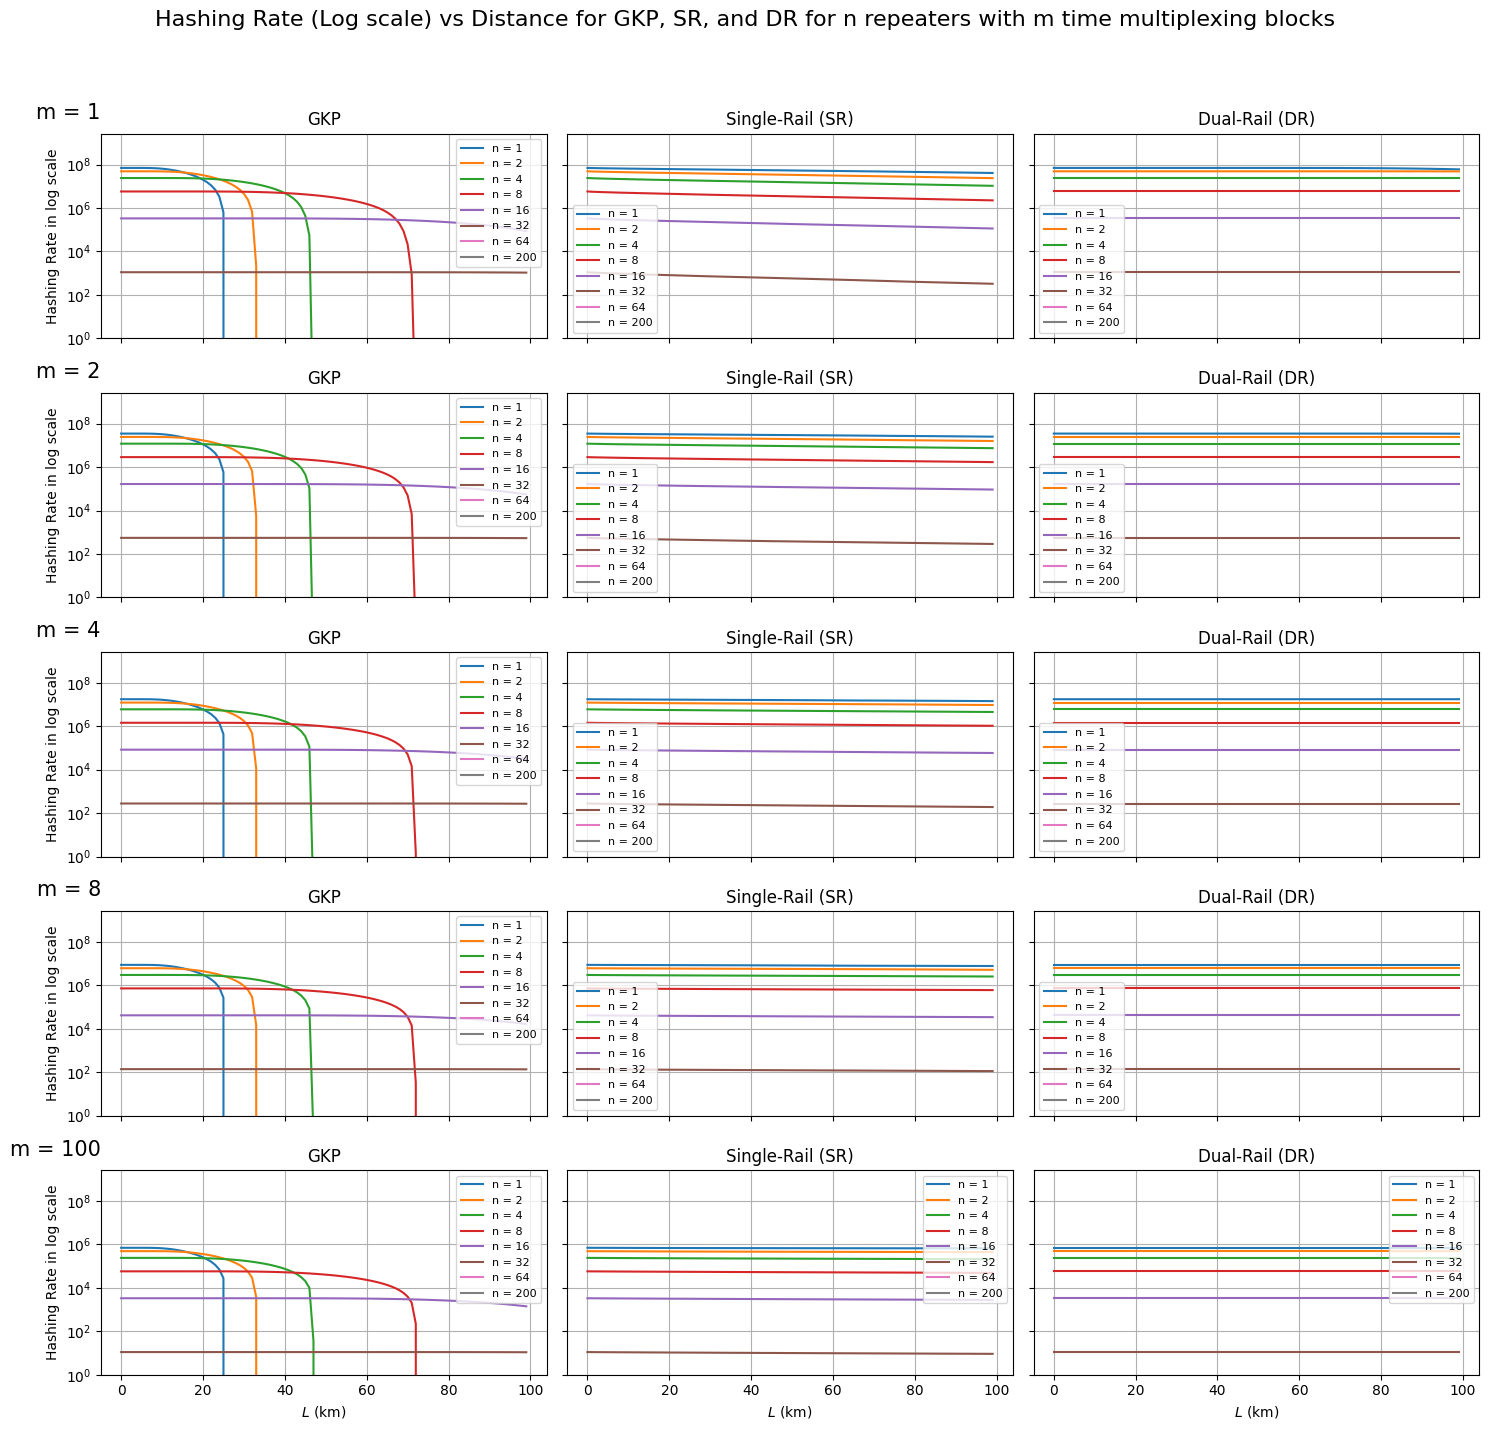

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

multi_n_data = [
    (1, Ls, [rates1, rates2, rates4, rates8, rates16, rates32, rates64 , rates200],
        [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16, ratesSR32, ratesSR64 , ratesSR200],
        [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16, ratesDR32, ratesDR64 , ratesDR200]),
    (2, Ls, [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16, m2rates32, m2rates64 , m2rates200],
        [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16, m2ratesSR32, m2ratesSR64 , m2ratesSR200],
        [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16, m2ratesDR32, m2ratesDR64 , m2ratesDR200]),
    (4, Ls, [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16, m4rates32, m4rates64 , m4rates200],
        [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16, m4ratesSR32, m4ratesSR64 , m4ratesSR200],
        [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16, m4ratesDR32, m4ratesDR64 , m4ratesDR200]),
    (8, Ls, [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16, m8rates32, m8rates64 , m8rates200],
        [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16, m8ratesSR32, m8ratesSR64 , m8ratesSR200],
        [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16, m8ratesDR32, m8ratesDR64 , m8ratesDR200]),
    (100, Ls, [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16, m100rates32, m100rates64 , m100rates200],
         [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16, m100ratesSR32, m100ratesSR64 , m100ratesSR200],
         [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16, m100ratesDR32, m100ratesDR64 , m100ratesSR200]),
]

n_vals = [1, 2, 4, 8, 16, 32, 64 , 200]

for row, (m, Ls, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):
    # Annotate m value on the left of each row
    axes[row, 0].annotate(f"m = {m}", xy=(0.0, 1.1), xycoords="axes fraction",
                          fontsize=15, rotation=0, va="center", ha="right")

    # GKP
    for i, rate_curve in enumerate(gkp_list):
        axes[row, 0].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 0].set_title("GKP")
    axes[row, 0].set_yscale("log")

    # SR
    for i, rate_curve in enumerate(sr_list):
        axes[row, 1].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 1].set_title("Single-Rail (SR)")
    axes[row, 1].set_yscale("log")

    # DR
    for i, rate_curve in enumerate(dr_list):
        axes[row, 2].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 2].set_title("Dual-Rail (DR)")
    axes[row, 2].set_yscale("log")

    for col in range(3):
        axes[row, col].grid(True)
        axes[row, col].legend(fontsize=8)
        axes[row, col].set_ylim(bottom=1)
        if row == 4:
            axes[row, col].set_xlabel("$L$ (km)")
        if col == 0:
            axes[row, col].set_ylabel("Hashing Rate in log scale")

fig.suptitle("Hashing Rate (Log scale) vs Distance for GKP, SR, and DR for n repeaters with m time multiplexing blocks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 2000 , 20)


sigma1 = np.sqrt(0.01)
rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]


ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]


ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [19]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 2000 , 20)


sigma1 = np.sqrt(0.01)
m2rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]


m2ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]


m2ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [20]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 2000 , 20)


sigma1 = np.sqrt(0.01)
m4rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]


m4ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]


m4ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [21]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 2000 , 20)


sigma1 = np.sqrt(0.01)
m8rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]


m8ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]


m8ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [22]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 2000 , 20)


sigma1 = np.sqrt(0.01)
m100rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]


m100ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]


m100ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_46838/14077029.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

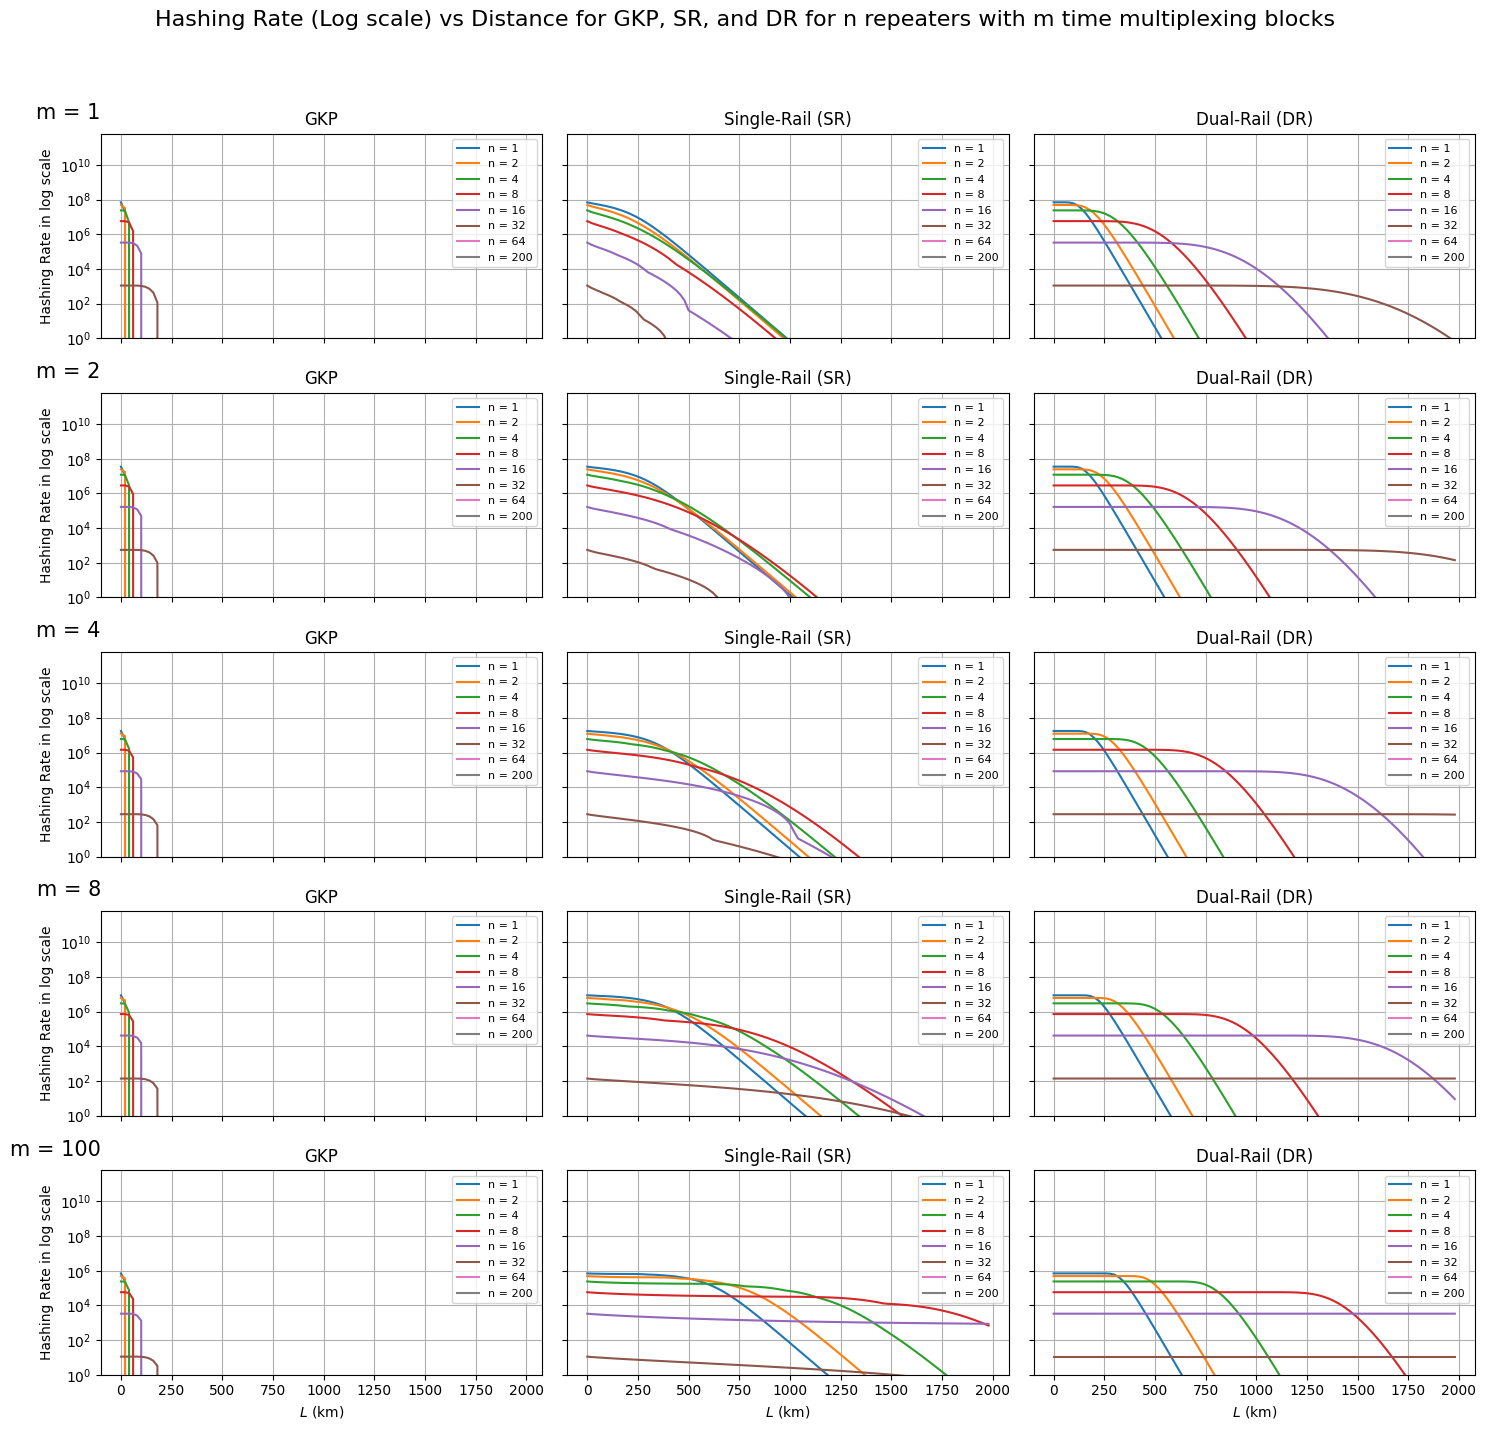

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

multi_n_data = [
    (1, Ls, [rates1, rates2, rates4, rates8, rates16, rates32, rates64 , rates200],
        [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16, ratesSR32, ratesSR64 , ratesSR200],
        [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16, ratesDR32, ratesDR64 , ratesDR200]),
    (2, Ls, [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16, m2rates32, m2rates64 , m2rates200],
        [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16, m2ratesSR32, m2ratesSR64 , m2ratesSR200],
        [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16, m2ratesDR32, m2ratesDR64 , m2ratesDR200]),
    (4, Ls, [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16, m4rates32, m4rates64 , m4rates200],
        [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16, m4ratesSR32, m4ratesSR64 , m4ratesSR200],
        [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16, m4ratesDR32, m4ratesDR64 , m4ratesDR200]),
    (8, Ls, [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16, m8rates32, m8rates64 , m8rates200],
        [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16, m8ratesSR32, m8ratesSR64 , m8ratesSR200],
        [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16, m8ratesDR32, m8ratesDR64 , m8ratesDR200]),
    (100, Ls, [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16, m100rates32, m100rates64 , m100rates200],
         [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16, m100ratesSR32, m100ratesSR64 , m100ratesSR200],
         [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16, m100ratesDR32, m100ratesDR64 , m100ratesSR200]),
]

n_vals = [1, 2, 4, 8, 16, 32, 64 , 200]

for row, (m, Ls, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):
    # Annotate m value on the left of each row
    axes[row, 0].annotate(f"m = {m}", xy=(0.0, 1.1), xycoords="axes fraction",
                          fontsize=15, rotation=0, va="center", ha="right")

    # GKP
    for i, rate_curve in enumerate(gkp_list):
        axes[row, 0].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 0].set_title("GKP")
    axes[row, 0].set_yscale("log")

    # SR
    for i, rate_curve in enumerate(sr_list):
        axes[row, 1].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 1].set_title("Single-Rail (SR)")
    axes[row, 1].set_yscale("log")

    # DR
    for i, rate_curve in enumerate(dr_list):
        axes[row, 2].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 2].set_title("Dual-Rail (DR)")
    axes[row, 2].set_yscale("log")

    for col in range(3):
        axes[row, col].grid(True)
        axes[row, col].legend(fontsize=8)
        axes[row, col].set_ylim(bottom=1)
        if row == 4:
            axes[row, col].set_xlabel("$L$ (km)")
        if col == 0:
            axes[row, col].set_ylabel("Hashing Rate in log scale")

fig.suptitle("Hashing Rate (Log scale) vs Distance for GKP, SR, and DR for n repeaters with m time multiplexing blocks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()